# Module 8 - Functional analysis

This notebook will demonstrate how one can perform functional analysis using `R`. This type of analysis is very useful to help interpret long gene lists and make biological sense of them.

In this lesson, the main package we will be using is called [clusterProfiler](https://www.bioconductor.org/packages//release/bioc/html/clusterProfiler.html). This package provides many useful functions to perform different types of functional analysis using different pathway databases.

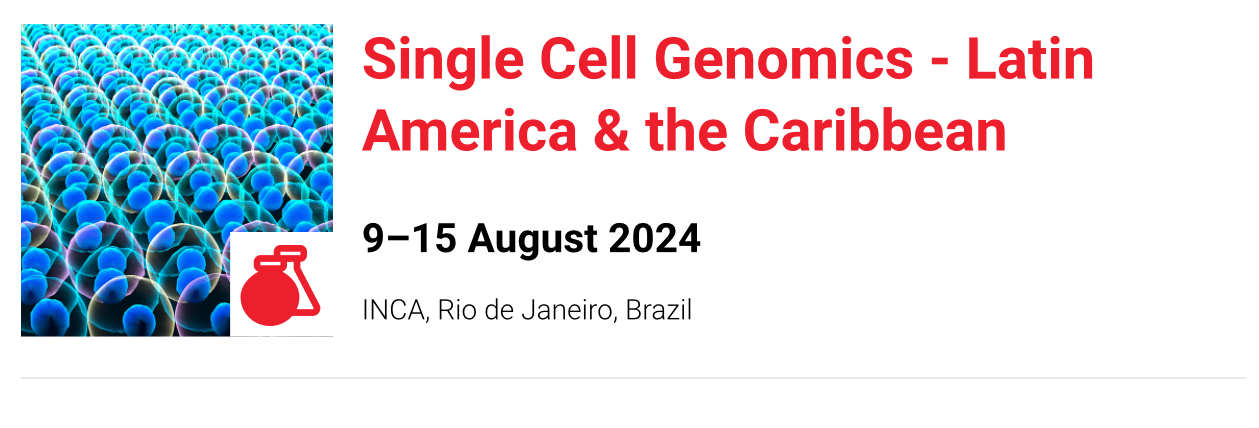

## Pre-analysis steps...

### Install & load required packages

In [ ]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)

In [ ]:
install.packages(c("ggplot2", "RColorBrewer", "dplyr", "readr"))
install.packages("BiocManager")
BiocManager::install(c("clusterProfiler", "org.Hs.eg.db", "ReactomePA"))


In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(ggplot2)
library(enrichplot)
library(RColorBrewer)
library(readr)
library(ReactomePA)

### Load gene list

In [ ]:
markers <- readr::read_csv("https://github.com/benilton/wcs-rio/raw/main/degs_c2xc0.csv.gz")
markers |> head()

### Prepare data

The first thing we need to do is prepare our gene list for functional analysis. We will be doing two different types of analysis - over-representation analysis (ORA) and gene set enrichment analysis (GSEA) - and the input data varies a little bit for each.

For ORA, we will need to pre-filter our gene list. We can use log fold change and adjusted p-value as filtering criteria, therefore we will need to set thresholds for them. It is very common to use the following cut-offs:

* `adjusted p-value` $\leq$ `0.05`
* `|log fold change|` $\geq$ `2`

We will need to split our gene list into 3 categories:

*   `both`: this category will include both upregulated and downregulated genes (i.e. `adjusted p-value` $\leq$ `0.05` and `|log fold change|` $\geq$ `2`)
*   `upregulated`: only upregulated genes (i.e. `adjusted p-value` $\leq$ `0.05` and `log fold change` $\geq$ `2`)
*   `downregulated`: only downregulated genes (i.e. `adjusted p-value` $\leq$ `0.05` and `log fold change` $\leq$ `-2`)



In [ ]:
my_genes_for_ora <- list(
  "both" = markers$gene[markers$p_val_adj <= 0.05 & abs(markers$avg_log2FC) >= 2],
  "upregulated" = markers$gene[markers$p_val_adj <= 0.05 & markers$avg_log2FC >= 2],
  "downregulated" = markers$gene[markers$p_val_adj <= 0.05 & markers$avg_log2FC <= -2]
)

In [ ]:
my_genes_for_ora

For GSEA, we don't need to filter our gene list according to `log fold change`; the only filtering we will do is by `adjusted p-value`!

In [ ]:
my_genes_for_gsea <- markers$avg_log2FC[markers$p_val_adj <= 0.05]
names(my_genes_for_gsea) <- markers$gene[markers$p_val_adj <= 0.05]
my_genes_for_gsea <- sort(my_genes_for_gsea, decreasing = TRUE)

In [ ]:
my_genes_for_gsea

### Creating some plotting functions

#### ORA bar plot

In [ ]:
make_ora_barplot <- function(ora_results, n_terms, db, title) {

  ora_results_filt <- ora_results[order(ora_results$p.adjust, decreasing = FALSE), ] %>% head(n_terms)

  ggplot(ora_results_filt, aes(x = Count, y = reorder(Description, Count), fill = -log10(p.adjust))) +
    geom_col(color = "black") +
    theme_classic() +
    theme(
      axis.text = element_text(size = 8),
      axis.title = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5)
    ) +
    xlab("Gene count") +
    ylab(paste0(db, " term")) +
    scale_fill_gradientn(
      colors = colorRampPalette(brewer.pal(9, "Reds"))(100),
      name = expression("-log"[10]~"(Adjusted p-value)")
    ) +
    ggtitle(title)

}

#### ORA dot plot

In [ ]:
make_ora_dotplot <- function(ora_results, n_terms, db, title) {

  ora_results_filt <- ora_results[order(ora_results$p.adjust, decreasing = FALSE), ] %>% head(n_terms)

  ggplot(ora_results_filt, aes(x = Count, y = reorder(Description, Count), fill = -log10(p.adjust))) +
    geom_point(size = 5, alpha = 0.8, shape = 21, color = "black") +
    theme_bw() +
    theme(
      axis.text = element_text(size = 8),
      axis.title = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5)
    ) +
    xlab("Gene count") +
    ylab(paste0(db, " term")) +
    scale_fill_gradientn(
      colors = colorRampPalette(brewer.pal(9, "Reds"))(100),
      name = expression("-log"[10]~"(Adjusted p-value)")
    ) +
    ggtitle(title)

}

#### GSEA bar plot

In [ ]:
make_gsea_barplot <- function(gsea_results, n_terms, db, title) {

  gsea_results_sorted <- gsea_results[order(gsea_results$NES, decreasing = TRUE), ]
  gsea_results_filt <- rbind(head(gsea_results_sorted, n_terms), tail(gsea_results_sorted, n_terms))

  ggplot(gsea_results_filt, aes(x = NES, y = reorder(Description, NES), fill = -log10(p.adjust))) +
    geom_col(color = "black") +
    theme_classic() +
    theme(
      axis.text = element_text(size = 8),
      axis.title = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5)
    ) +
    xlab("Normalised enrichment score") +
    ylab(paste0(db, " term")) +
    scale_fill_gradientn(
      colors = colorRampPalette(brewer.pal(9, "Reds"))(100),
      name = expression("-log"[10]~"(Adjusted p-value)")
    ) +
    ggtitle(title)

}

## Part I - Over-representation analysis (ORA)

In today's lesson, we will be doing ORA with the [Gene Ontology (GO)](https://geneontology.org/) and [Kyoto Encyclopedia of Genes and Genomes (KEGG)](https://www.genome.jp/kegg/:) databases.

The ORA logic is pretty much the same regardless of the database you use. The main difference will be that, to do ORA using different databases, we will need to use different functions from the package `clusterProfiler`.

### Gene Ontology (GO)

#### GO - Both up and downregulated genes

Let's start by performing ORA on all genes of interest, stored at `my_genes_for_ora$both`. Note that `my_genes_for_ora$both` contains both upregulated and downregulated genes.

In [ ]:
go_ora_both <- enrichGO(
  gene = my_genes_for_ora$both,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  keyType = "SYMBOL",
  pvalueCutoff = 0.05
)

We can check what `go_ora_both` looks like:

In [ ]:
go_ora_both

We can plot the results using the functions `make_ora_barplot` and `make_ora_dotplot`, which we created above. Note that you can access the ORA results in the slot `result` of the `enrichResults` object generated by the function `enrichGO()`, as in `go_ora_both@result`.

In [ ]:
make_ora_barplot(ora_results = go_ora_both@result, n_terms = 10, db = "GO", title = "All DEGs")

In [ ]:
make_ora_dotplot(ora_results = go_ora_both@result, n_terms = 10, db = "GO", title = "All DEGs")

When we do ORA on a gene list containing both up and downregulated genes, it is not straightforward to look at the results and know if a given process or pathway is enriched in the up or downregulated genes. We can therefore perform ORA twice, on two separate gene lists.

We will now be using the genes stored at `my_genes_for_ora$upregulated` and `my_genes_for_ora$downregulated`.

#### GO - Only upregulated genes

First, let's use the list of upregulated genes and find out which GO terms are enriched there:

In [ ]:
go_ora_up <- enrichGO(
  gene = my_genes_for_ora$upregulated,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  keyType = "SYMBOL"
)

In [ ]:
go_ora_up

In [ ]:
make_ora_barplot(ora_results = go_ora_up@result, n_terms = 10, db = "GO", title = "Up DEGs")

In [ ]:
make_ora_dotplot(ora_results = go_ora_up@result, n_terms = 10, db = "GO", title = "Up DEGs")

#### GO - Only downregulated genes

Now let's do the same with the list of downregulated genes:

In [ ]:
go_ora_down <- enrichGO(
  gene = my_genes_for_ora$downregulated,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  keyType = "SYMBOL"
)

In [ ]:
go_ora_down

In [ ]:
make_ora_barplot(ora_results = go_ora_down@result, n_terms = 10, db = "GO", title = "Down DEGs")

In [ ]:
make_ora_dotplot(ora_results = go_ora_down@result, n_terms = 10, db = "GO", title = "Down DEGs")

### Kyoto Encyclopedia of Genes and Genomes (KEGG)

We have just studied how to perform ORA using the GO database. Now we will use a different database, KEGG.

When we used GO, the `clusterProfiler` function we needed for ORA was called `enrichGO()`. ORA with KEGG, on the other hand, will require the function `enrichKEGG()`.

The `enrichKEGG()` function will require ENTREZ gene IDs, and we currently have only gene symbols. The convertion between IDs can be easily done using the `bitr()` function.

To facilitate our work, we will define a function that will take a gene list as input and then do the following steps:


1.   Convert gene symbols to ENTREZ IDs using `bitr()`
2.   Run ORA using `enrichKEGG()`
3.   Return the ORA results



In [ ]:
run_ora_with_kegg <- function(gene_list) {

  cat("Converting gene IDs...\n\n")

  converted_ids <- bitr(
    geneID = gene_list,
    fromType = "SYMBOL",
    toType = "ENTREZID",
    OrgDb = org.Hs.eg.db
  )

  cat("\nPerforming ORA with KEGG...\n\n")

  kegg_ora <- enrichKEGG(
    gene = converted_ids$ENTREZID,
    organism = "hsa",
    pvalueCutoff = 0.05
  )

  cat("Done!\n\n")

  return(kegg_ora)

}

Now that we have the function `run_ora_with_kegg()`, we can easily perform the ID conversion followed by ORA on all the gene lists we stored at `my_genes_for_ora`!

#### KEGG - Both up and downregulated genes

In [ ]:
kegg_ora_both <- run_ora_with_kegg(gene_list = my_genes_for_ora$both)

In [ ]:
kegg_ora_both

In [ ]:
make_ora_barplot(ora_results = kegg_ora_both@result, n_terms = 10, db = "KEGG", title = "All DEGs")

In [ ]:
make_ora_dotplot(ora_results = kegg_ora_both@result, n_terms = 10, db = "KEGG", title = "All DEGs")

#### KEGG - Only upregulated genes

In [ ]:
kegg_ora_up <- run_ora_with_kegg(gene_list = my_genes_for_ora$upregulated)

In [ ]:
kegg_ora_up

In [ ]:
make_ora_barplot(ora_results = kegg_ora_up@result, n_terms = 10, db = "KEGG", title = "Up DEGs")

In [ ]:
make_ora_dotplot(ora_results = kegg_ora_up@result, n_terms = 10, db = "KEGG", title = "Up DEGs")

#### KEGG - Only downregulated genes

In [ ]:
kegg_ora_down <- run_ora_with_kegg(gene_list = my_genes_for_ora$downregulated)

In [ ]:
kegg_ora_down

In [ ]:
make_ora_barplot(ora_results = kegg_ora_down@result, n_terms = 10, db = "KEGG", title = "Down DEGs")

In [ ]:
make_ora_dotplot(ora_results = kegg_ora_down@result, n_terms = 10, db = "KEGG", title = "Down DEGs")

## Part II - Gene set enrichment analysis (GSEA)

For GSEA, we will be using the [GO database](https://geneontology.org/).

### GO

In [ ]:
go_gsea <- gseGO(
  geneList = my_genes_for_gsea,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  pvalueCutoff = 0.05,
  verbose = TRUE,
  keyType = "SYMBOL"
)

In [ ]:
go_gsea

In [ ]:
make_gsea_barplot(gsea_results = go_gsea@result, n_terms = 10, db = "GO", title = "GSEA")

In [ ]:
gseaplot(go_gsea, geneSetID = 1, title = go_gsea$Description[1])

## Exercise

Using the genes stored in `my_genes_for_ora`, perform an over-representation analysis using the Reactome database. You can use the code above as a reference, and you can also refer to the `clusterProfiler` documentation [here](http://yulab-smu.top/biomedical-knowledge-mining-book/reactomepa.html). Hint: you can use the function `enrichPathway()`